In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
def to_var(x, volatile=False):
	if torch.cuda.is_available():
		x = x.cuda()

	return Variable(x, volatile=volatile)

In [3]:
class Encoder(nn.Module):

    def __init__(self):
        """Encoder"""
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
        nn.Conv2d(1, 32, kernel_size = 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size = 3, stride=2, padding=1),
        nn.ReLU(),  
        ])

    def forward(self, images):
        """Extract the image feature vectors."""
        features = images
        for layer in self.layers:
            features = layer(features)
        return features

class Decoder(nn.Module):

    def __init__(self):
        """Decoder"""
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
        nn.Sigmoid()
        ])

    def forward(self, images):
        """Extract the image feature vectors."""
        features = images
        for layer in self.layers:
            features = layer(features)
        return features

class ClusterNet(nn.Module):

    def __init__(self, n_clusters=10):
        """ClusterNet("""
        super(ClusterNet, self).__init__()
        self.layers = nn.ModuleList([
        nn.Conv2d(1, 32, kernel_size = 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size = 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size = 3, stride=2, padding=1),
        nn.MaxPool2d(2),
        nn.ReLU(),    
        nn.Flatten(),
        nn.Linear(256, n_clusters),          
        nn.Softmax(dim=0),

        ])

    def forward(self, images):
        """Extract the image feature vectors."""
        features = images
        for layer in self.layers:
            features = layer(features)
        return features

In [4]:
class AutoEncoderDataset(Dataset):
    
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx]

In [5]:
def train_autoencoder(autoencoder, optimizer, criterion, data_loader, number_of_epochs=1, name='main', verbose=False):
    print('Training %s ...'%(name))
    for epoch in range(number_of_epochs):

        running_loss = 0.0
        autoencoder.train()
        for batch_index, (in_images, labels) in enumerate(data_loader):
            
            in_images = to_var(in_images)
            out_images = autoencoder(in_images)

            loss = criterion(out_images, in_images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.data.numpy()
            if batch_index % 100==0 and verbose:
                print('epoch %d loss: %.5f batch: %d' % (epoch, running_loss/((batch_index + 1)), (batch_index + 1)*batch_size))
            if batch_index != 0 and batch_index % 1000 == 0:
                break
    print('Done training %s'%(name))

In [6]:
batch_size = 8
train_loader = DataLoader( 
    torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size, shuffle=True)

test_loader = DataLoader( 
    torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=2000, shuffle=False)

In [7]:
def init_autoencoder_mixture(train_loader, test_loader, n_clusters=10):
    autoencoder_mixture = {}
    
    autoencoder_main = nn.Sequential(Encoder(), Decoder())
    criterion = nn.BCELoss()
    optimizer = optim.Adam(autoencoder_main.parameters(), lr=1e-3)
    number_of_epochs = 5
    
    train_autoencoder(autoencoder_main , optimizer, criterion, train_loader, number_of_epochs, name='main')
    
    dataiter = iter(test_loader)
    in_images = dataiter.next()[0]
    autoencoder_main.eval()
    init_data = autoencoder_main[0](to_var(in_images)).data.view(in_images.shape[0],-1).numpy()
    
    autoencoder_mixture['autoencoder_main'] = autoencoder_main
    
    print('Clustering ...')

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(init_data)
    print('Done Clustering !!')
    for cluster in range(n_clusters):
        autoencoder_mixture[cluster] = {}
        ds = AutoEncoderDataset(in_images[kmeans.labels_==cluster])
        autoencoder_mixture[cluster]['autoencoder'] = nn.Sequential(Encoder(), Decoder())
        optimizer = optim.Adam(autoencoder_mixture[cluster]['autoencoder'].parameters(), lr=1e-2)
        criterion = nn.BCELoss()
        data_loader = DataLoader(ds, batch_size=4, shuffle=True)
        
        train_autoencoder(autoencoder_mixture[cluster]['autoencoder'], 
                          optimizer,
                          criterion,
                          data_loader, 
                          number_of_epochs = 10, 
                          name='cluster_'+ str(cluster))
        
        test_image = iter(data_loader).next()[0]
        autoencoder_mixture[cluster]['autoencoder'].eval()
        recon_image = autoencoder_mixture[cluster]['autoencoder'](to_var(test_image))
        plt.subplot(10, 10, cluster + 1)
        plt.imshow(test_image[0].numpy().squeeze(0))
        plt.subplot(10, 10, cluster + 11)
        plt.imshow(recon_image[0].data.numpy().squeeze(0))
    
    autoencoder_mixture['cluster_net'] = ClusterNet()
    plt.show()
    return autoencoder_mixture

Training main ...
Done training main
Clustering ...
Done Clustering !!
Training cluster_0 ...
Done training cluster_0
Training cluster_1 ...
Done training cluster_1
Training cluster_2 ...
Done training cluster_2
Training cluster_3 ...
Done training cluster_3
Training cluster_4 ...
Done training cluster_4
Training cluster_5 ...
Done training cluster_5
Training cluster_6 ...
Done training cluster_6
Training cluster_7 ...
Done training cluster_7
Training cluster_8 ...
Done training cluster_8
Training cluster_9 ...
Done training cluster_9


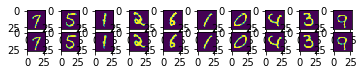

In [8]:
autoencoder_mixture = init_autoencoder_mixture(train_loader, test_loader, n_clusters=10)

In [9]:
def get_mixure_output(autoencoder_mixture, images, n_clusters=10):
    output = []
    for cluster in range(n_clusters):
        output.append(autoencoder_mixture[cluster]['autoencoder'](images))
    return output

In [33]:
def autoencoder_mixure_loss_fn(images, mixure_outputs, clustering_net_output, n_clusters=10):
    loss = 0 
    for cluster in range(n_clusters):
        mse = -((mixure_outputs[cluster] - images)**2).mean(axis=(1, 2, 3))
        loss += clustering_net_output[:, cluster] * torch.exp(mse) 
    loss = -torch.log(loss).sum()
    return loss
        


In [34]:
images = to_var(torch.rand(5, 1, 28, 28))
mixure_outputs = [to_var(torch.rand(5, 1, 28, 28))]*10
clustering_net_output = nn.functional.softmax(to_var(torch.randn(5, 10) +1 ), dim=1)

print(autoencoder_mixure_loss_fn(images, mixure_outputs, clustering_net_output, n_clusters=10))

tensor(0.8536)


In [43]:
def train_autoencoder_mixure(autoencoder_mixture, data_loader, number_of_epochs=1, n_clusters = 10, name='main', verbose=False):
    print('Training %s ...'%(name))

    params = list(autoencoder_mixture['cluster_net'].parameters())
    
    for cluster in range(n_clusters):
        params += list(autoencoder_mixture[cluster]['autoencoder'].parameters())        
        autoencoder_mixture[cluster]['autoencoder'].train()
        
    optimizer = optim.Adam(params, lr=1e-2)
    number_of_epochs = 5

    for epoch in range(number_of_epochs):
        running_loss = 0.0
        autoencoder_mixture['cluster_net'].train()
        
        for batch_index, (in_images, labels) in enumerate(data_loader):

            in_images = to_var(in_images)
            mixure_outputs = get_mixure_output(autoencoder_mixture, in_images, n_clusters=10)
            clustering_net_outputs = autoencoder_mixture['cluster_net'](in_images)
            loss = autoencoder_mixure_loss_fn(in_images, mixure_outputs, clustering_net_outputs, n_clusters=10)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.data.numpy()
            if batch_index % 100==0 and verbose:
                print('epoch %d loss: %.5f batch: %d' % (epoch, running_loss/((batch_index + 1)), (batch_index + 1)*batch_size))
            if batch_index != 0 and batch_index % 1000 == 0:
                break

In [ ]:

    
train_autoencoder_mixure(autoencoder_mixture,  
                         train_loader, 
                         number_of_epochs=1, 
                         name='autoencoder mixture', verbose=True)

Training autoencoder mixture ...
epoch 0 loss: -1.77689 batch: 8
epoch 0 loss: -1.77335 batch: 808
epoch 0 loss: -1.77502 batch: 1608
epoch 0 loss: -1.77598 batch: 2408
epoch 0 loss: -1.77655 batch: 3208
epoch 0 loss: -1.77693 batch: 4008
epoch 0 loss: -1.77723 batch: 4808
epoch 0 loss: -1.77752 batch: 5608
epoch 0 loss: -1.77777 batch: 6408
epoch 0 loss: -1.77801 batch: 7208
epoch 0 loss: -1.77821 batch: 8008
epoch 1 loss: -1.77959 batch: 8
epoch 1 loss: -1.78023 batch: 808
epoch 1 loss: -1.78038 batch: 1608
epoch 1 loss: -1.78049 batch: 2408
epoch 1 loss: -1.78054 batch: 3208
epoch 1 loss: -1.78064 batch: 4008
epoch 1 loss: -1.78072 batch: 4808
epoch 1 loss: -1.78080 batch: 5608
epoch 1 loss: -1.78086 batch: 6408
epoch 1 loss: -1.78090 batch: 7208
epoch 1 loss: -1.78096 batch: 8008
epoch 2 loss: -1.78267 batch: 8
epoch 2 loss: -1.78148 batch: 808
epoch 2 loss: -1.78155 batch: 1608
epoch 2 loss: -1.78155 batch: 2408
epoch 2 loss: -1.78156 batch: 3208
epoch 2 loss: -1.78162 batch: 4008